In [3]:
import pickle
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import recall_score, f1_score, precision_score, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [4]:
# Load pickle file with balanced dataframe
with open(r'pickles\balanced_retokenized_en.pickle', 'rb') as f:
    data = pickle.load(f)

### Representação vetorial (Tf-Idf)

In [5]:
# Split data into features (X) and label (y)
X_data = np.array(data['title'])
y_data = np.array(data['label'])

# Apply Tf-Idf representation
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(X_data)
X_data = vectorizer.transform(X_data)

### Redução de Dimensionalidade

#### Extração de Features (LSA - TruncatedSVD)

In [6]:
LSA = TruncatedSVD(n_components=100, n_iter=150, random_state=0)
LSA = LSA.fit(X_data)
X_data = LSA.transform(X_data)

## Modelagem de algoritmos

#### Naive Bayes

In [7]:
NB_classifier = GaussianNB()

#### Logistic Regression

In [8]:
LR_classifier = LogisticRegression(solver='saga', C=1000, penalty='l2', max_iter=1000)

#### K-Nearest-Neighboors

In [9]:
KNN_classifier = KNeighborsClassifier(n_neighbors=3)

#### Support Vector Machine

In [10]:
SVM_classifier = SVC(kernel='rbf', probability=True, gamma='scale', C=100)

#### Multilayer Perceptron

In [11]:
MLP_classifier = MLPClassifier(hidden_layer_sizes=(100,50,50,25), activation='relu', solver='adam', alpha=0.0001, learning_rate='constant', max_iter=1000)

In [12]:
def metrics(classifier, cv):
    print(f'======= MODEL {classifier.__class__.__name__} =======')
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots(figsize=(12,7))
    for i, (train, test) in enumerate(cv.split(X_data, y_data)):
        start_time = time.time()
        classifier.fit(X_data[train], y_data[train])
        predicted = classifier.predict(X_data[test])
        print(f'Cross-validate k={i}: precision={precision_score(predicted, y_data[test])}, recall={recall_score(predicted, y_data[test])}, f1={f1_score(predicted, y_data[test])}, time={time.time() - start_time}s')
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X_data[test],
            y_data[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"ROC médio (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 desv. pad.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title=f"ROC para o modelo {classifier.__class__.__name__} com validação cruzada 10-fold",
    )
    ax.legend(loc="lower right")
    ax.set_xlabel('Taxa de Falso Positivo (FP) (classe positiva: 1)', fontsize=12)
    ax.set_ylabel('Taxa de Verdadeiro Positivo (VP) (classe positiva: 1)', fontsize=12)
    plt.show()

======= MODEL GaussianNB =======
Cross-validate k=0: precision=0.812755519215045, recall=0.7473684210526316, f1=0.7786917352134743, time=0.03636050224304199s
Cross-validate k=1: precision=0.8078495502861816, recall=0.7536231884057971, f1=0.7797947908445146, time=0.039571523666381836s
Cross-validate k=2: precision=0.759607522485691, recall=0.7332280978689818, f1=0.7461847389558232, time=0.03715109825134277s
Cross-validate k=3: precision=0.8331970564186427, recall=0.7621540762902019, f1=0.7960937499999999, time=0.03752875328063965s
Cross-validate k=4: precision=0.8062142273098937, recall=0.61090458488228, f1=0.6951004582305251, time=0.03748011589050293s
Cross-validate k=5: precision=0.8423202614379085, recall=0.5918484500574053, f1=0.6952124072825353, time=0.03634381294250488s
Cross-validate k=6: precision=0.8888888888888888, recall=0.6171298922291548, f1=0.7284901238701038, time=0.0362703800201416s
Cross-validate k=7: precision=0.8528209321340965, recall=0.6014994232987313, f1=0.7054447

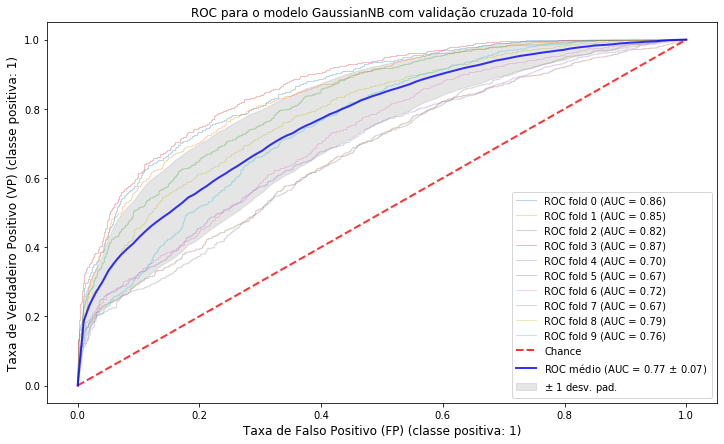

======= MODEL LogisticRegression =======
Cross-validate k=0: precision=0.7269010629599346, recall=0.8961693548387096, f1=0.802708803611738, time=0.4617958068847656s
Cross-validate k=1: precision=0.7130008176614882, recall=0.9017580144777663, f1=0.7963470319634702, time=0.5504345893859863s
Cross-validate k=2: precision=0.7514309076042518, recall=0.8939688715953308, f1=0.816525988449578, time=0.545100212097168s
Cross-validate k=3: precision=0.8397383483237939, recall=0.9048458149779736, f1=0.8710771840542832, time=0.5952894687652588s
Cross-validate k=4: precision=0.8356500408830744, recall=0.7855495772482706, f1=0.8098256735340729, time=0.5456945896148682s
Cross-validate k=5: precision=0.8913398692810458, recall=0.7946103423160962, f1=0.8402002310358105, time=0.5231292247772217s
Cross-validate k=6: precision=0.923202614379085, recall=0.7863604732080723, f1=0.8493047726418641, time=0.5315723419189453s
Cross-validate k=7: precision=0.9084219133278822, recall=0.7578444747612552, f1=0.826329

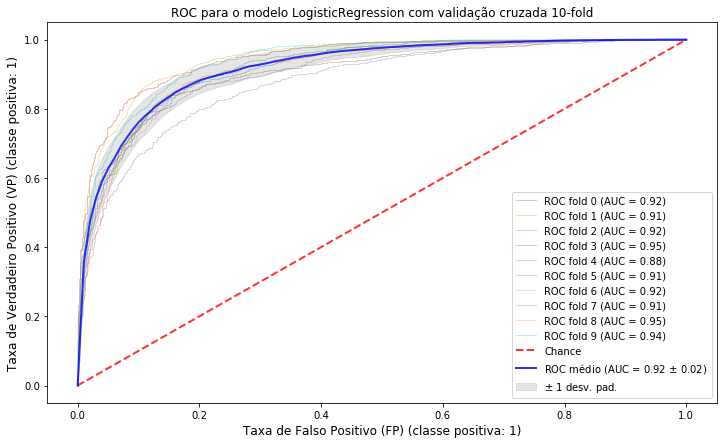

======= MODEL KNeighborsClassifier =======
Cross-validate k=0: precision=0.7686017988552739, recall=0.8600182982616651, f1=0.8117443868739205, time=1.0221073627471924s
Cross-validate k=1: precision=0.7694194603434178, recall=0.8508137432188065, f1=0.8080721339630743, time=1.1089205741882324s
Cross-validate k=2: precision=0.8323793949304987, recall=0.8547439126784215, f1=0.8434134217067107, time=1.0503134727478027s
Cross-validate k=3: precision=0.8004905968928864, recall=0.851304347826087, f1=0.8251158870627897, time=1.0487451553344727s
Cross-validate k=4: precision=0.8691741618969746, recall=0.7620071684587814, f1=0.812070282658518, time=1.1058323383331299s
Cross-validate k=5: precision=0.8815359477124183, recall=0.765791341376863, f1=0.819597417394607, time=1.1127452850341797s
Cross-validate k=6: precision=0.869281045751634, recall=0.7698986975397974, f1=0.8165771297006907, time=1.039747953414917s
Cross-validate k=7: precision=0.8740801308258381, recall=0.7347079037800688, f1=0.798356

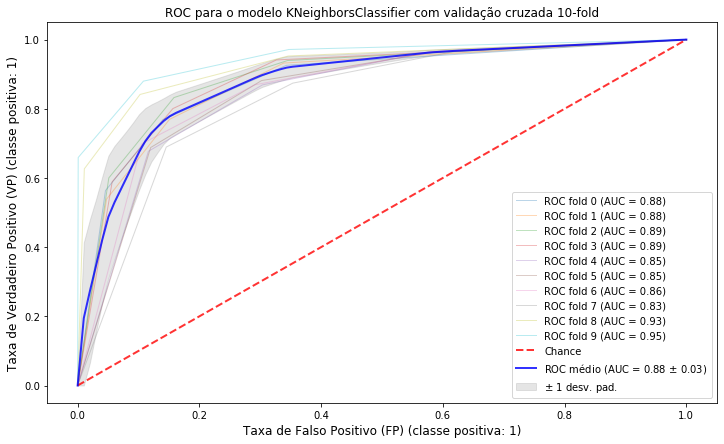

======= MODEL SVC =======
Cross-validate k=0: precision=0.7980376124284546, recall=0.9095992544268406, f1=0.8501742160278746, time=440.54659843444824s
Cross-validate k=1: precision=0.7939493049877351, recall=0.9024163568773235, f1=0.8447150935189214, time=429.05685448646545s
Cross-validate k=2: precision=0.8511856091578087, recall=0.9131578947368421, f1=0.8810833685992383, time=434.60710167884827s
Cross-validate k=3: precision=0.8699918233851186, recall=0.910958904109589, f1=0.890004182350481, time=438.95520091056824s
Cross-validate k=4: precision=0.884709730171709, recall=0.8159879336349924, f1=0.8489603766182816, time=316.49759221076965s
Cross-validate k=5: precision=0.9150326797385621, recall=0.827178729689808, f1=0.8688906128782001, time=324.6088137626648s
Cross-validate k=6: precision=0.9060457516339869, recall=0.8148420279206466, f1=0.858027079303675, time=321.02235674858093s
Cross-validate k=7: precision=0.9076042518397384, recall=0.8043478260869565, f1=0.8528620822128312, time=

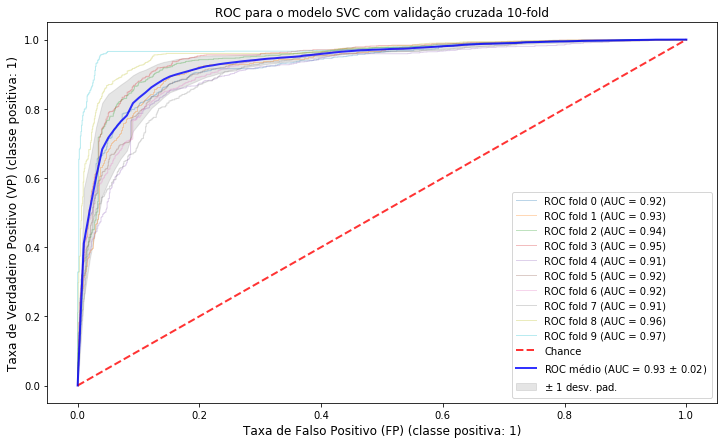

======= MODEL MLPClassifier =======
Cross-validate k=0: precision=0.7931316434995912, recall=0.9125117591721543, f1=0.8486439195100612, time=91.35935521125793s
Cross-validate k=1: precision=0.7784137367130008, recall=0.9118773946360154, f1=0.8398764887516542, time=95.50991082191467s
Cross-validate k=2: precision=0.8446443172526574, recall=0.9190391459074733, f1=0.88027268853856, time=50.71064877510071s
Cross-validate k=3: precision=0.884709730171709, recall=0.9279588336192109, f1=0.9058183340309752, time=51.40304446220398s
Cross-validate k=4: precision=0.8887980376124285, recall=0.8291380625476735, f1=0.8579321231254934, time=41.278380155563354s
Cross-validate k=5: precision=0.9256535947712419, recall=0.7962052002810963, f1=0.8560634680770683, time=73.13098406791687s
Cross-validate k=6: precision=0.9133986928104575, recall=0.846328538985617, f1=0.8785854616895874, time=51.14750838279724s
Cross-validate k=7: precision=0.9125102207686018, recall=0.7875793930839803, f1=0.8454545454545455,

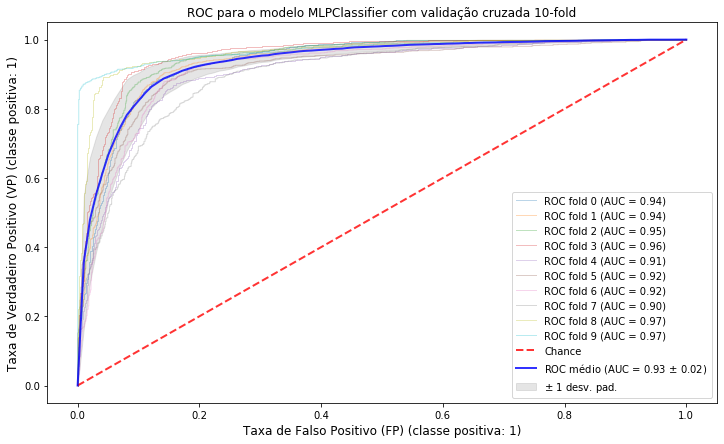

In [13]:
cv = StratifiedKFold(n_splits=10)
metrics(NB_classifier, cv)
metrics(LR_classifier, cv)
metrics(KNN_classifier, cv)
metrics(SVM_classifier, cv)
metrics(MLP_classifier, cv)